In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###  Import Trento outputs for 60,000 fluctuating events of PbPb collisions at 5.02 TeV with JETSCAPE MAP parameters


In [94]:
trento_out = np.fromfile('trento_MAP_grad.txt', sep=' ')

In [95]:
trento_out = trento_out.reshape(-1,8)

In [96]:
trento_out_df = pd.DataFrame(trento_out,columns=['event_number', 'impact_param', 'npart', 'mult', 'e2',
                                                 'e3', 'E', 'e5'])

In [97]:
trento_out_df = trento_out_df.iloc[0:60000]

### Find multiplicity observables by sorting the Trento outputs with integrated reduced thickness

In [98]:
trento_out_df_sorted = trento_out_df.sort_values(by='mult', axis=0, ignore_index=True, ascending=False)

In [99]:
trento_out_df_sorted

,event_number,impact_param,npart,mult,e2,e3,E,e5
0,2398.0,0.418453,411.0,3944.618867,0.128202,0.044632,21.410521,0.030978
1,44665.0,1.655650,406.0,3918.580009,0.084595,0.232619,21.048366,0.022597
2,48610.0,0.840844,410.0,3908.301204,0.147920,0.052234,20.932728,0.061456
3,18980.0,0.483397,414.0,3904.043731,0.043424,0.064592,21.907015,0.018521
4,16187.0,0.974428,413.0,3880.385054,0.037000,0.057856,20.909943,0.053856
...,...,...,...,...,...,...,...,...
59995,17915.0,16.870860,2.0,0.019019,0.105915,0.017108,0.000012,0.005019
59996,22869.0,17.509464,2.0,0.018550,0.090721,0.031338,0.000011,0.001662
59997,13221.0,17.106933,2.0,0.012692,0.109517,0.008148,0.000007,0.004504
59998,13283.0,18.534885,2.0,0.012570,0.053508,0.045377,0.000007,0.042567


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'b')

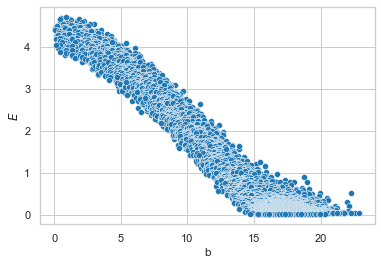

In [100]:
sns.set_context('notebook')
x = trento_out_df_sorted['impact_param']
y = np.sqrt(trento_out_df_sorted['E'])


ax=sns.scatterplot(x,y)
ax.set_ylabel(r'$E$')
ax.set_xlabel('b')

### Calculate $\rho$ for each centrality class

In [101]:
cent_classe = [[0,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70],[70,80]]

In [102]:
num_events = len(trento_out_df_sorted)
# We can find event centrality this way
# becausee the events were minimum biased.
event_cen = []

for cen_min, cen_max in cent_classe:
    #print(cen_min,cen_max)
    if cen_min==0:
        n_min=0
    n_max = int(np.floor(num_events * cen_max/100))
    event_cen.append([n_min,n_max])
    n_min = n_max+1
print('Event index ranges corresponding to centralities are as follows')
print(event_cen)

Event index ranges corresponding to centralities are as follows
[[0, 6000], [6001, 12000], [12001, 18000], [18001, 24000], [24001, 30000], [30001, 36000], [36001, 42000], [42001, 48000]]


In [103]:
def calculate_rho(pT_method=0):
    """Calculate rho as a function of centrality using the choosen method to calculate a psuedo observable for pT
    pT_method=0
    -----------
    Calculate pT assuming it's inversely propotional to the integrated reduced thickness function (multiplicity)
    pT_method=1:
    -----------
    Calculate pT assuming it's inversely propotional to the squre root of the integrated reduced
    thickness function (multiplicity)
    pT_method=2:
    Calculate pT assuming it's propotional to the impact parameter
    -----------
    pT_method=3:
    Calculate pT using R^2 value that Trento outputs acording to Giuliano GIACALONE thesis
    Return : 1D array of calculate rho parameter values"""
    
    
    rho = []
    for n_min, n_max in event_cen:
        v2 = np.square(trento_out_df_sorted['e2'][n_min:n_max])
        if pT_method==0:
            pT = np.divide(1,trento_out_df_sorted['mult'][n_min:n_max])
        if pT_method==1:
            pT = np.divide(1,np.sqrt(trento_out_df_sorted['mult'][n_min:n_max]))
        if pT_method==2:
            pT = trento_out_df_sorted['impact_param'][n_min:n_max]
        if pT_method==3:
            pT = np.divide(trento_out_df_sorted['E'][n_min:n_max],trento_out_df_sorted['mult'][n_min:n_max])
        X = np.vstack((v2,pT))
        #print(X.shape)
        rho_value = np.corrcoef(X)
        #print(rho_value)
        # We want the pearson corellation coefficient between v2 and pT. So take the off diagonal
        rho.append(rho_value[0,1])
    #print(rho)
    return(rho)

In [104]:
pT_methods = ['pT $\propto 1/multiplicity$', 'pT $\propto 1/\sqrt{multiplicity}$','pT $\propto b$', 'pT $\propto E/S$']



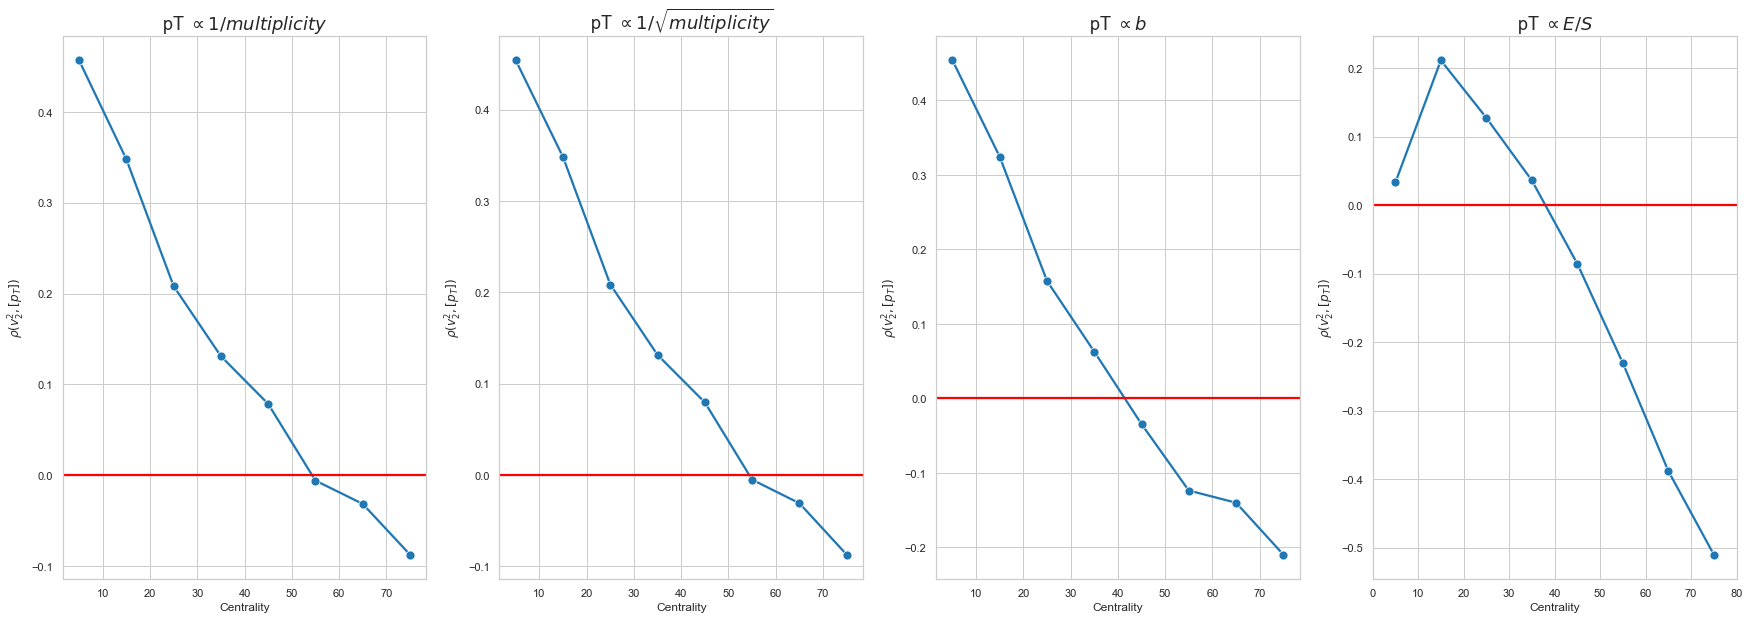

In [105]:
fig, axs = plt.subplots(1,4, figsize=(30,10),sharex=True, sharey=False)
sns.set_style('whitegrid')
sns.set_context('talk')
for i, ax in enumerate(axs):
    rho = calculate_rho(i)
    cen_array = [((mn+mx)/2) for mn,mx in cent_classe]
    sns.lineplot(x=cen_array, y=rho, marker="o",ax=ax)
    ax.axhline(color='r')
    ax.set_title(pT_methods[i])
    ax.set_xticks([0,10,20,30,40,50,60,70,80])
    #ax.set_xticklabels([0,10,20,30,40,50,60,70,80])
    ax.set_xlabel('Centrality')
    ax.set_ylabel(r'$\rho(v_2^{2},[p_T])$')